In [1]:
import numpy as np
import xarray as xr
import gcsfs
from matplotlib import pyplot as plt
from xgcm import Grid
from xhistogram.xarray import histogram
%matplotlib inline
from matplotlib import colors as cols
from matplotlib import colors

In [2]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")
ds01  = cat["channel_ridge_resolutions_01km"].to_dask()

In [3]:
grid01 = Grid(ds01, periodic='X')

In [4]:
horispace01 = 1e3
horispace05 = 5e3
horispace20 = 20e3
time_index = 0
depth = -50
f =  -0.83e-4
daytime = 86400
alpha = 2e-4
gravity = 9.81
dx = 1e3

In [5]:
u = grid01.interp(ds01.U,'X')
v = grid01.interp(ds01.V,'Y', boundary='extend')

In [6]:
ux = grid01.diff(ds01.U,'X')/dx
vy = grid01.diff(ds01.V,'Y', boundary='extend')/dx
uy = grid01.interp(grid01.interp(grid01.diff(ds01.U,'Y', boundary='extend')/dx, 'X'),
                 'Y', boundary='extend')
vx = grid01.interp(grid01.interp(grid01.diff(ds01.V,'X')/dx, 'X'),
                 'Y', boundary='extend')

In [7]:
speed = (u**2 + v**2)**0.5

In [8]:
curv = (u**2*vx - v**2*uy + u*v*(vy- ux))/speed**3

In [9]:
Cu = 2*speed/f*curv

In [10]:
b = gravity*alpha*ds01['T']

In [11]:
gradb2 = (grid01.interp(grid01.diff(b, 'X'),'X')/horispace01)**2 + (
        grid01.interp(grid01.diff(b, 'Y', boundary='extend'),
                      'Y',boundary='extend')/horispace01)**2
N2 = grid01.interp(grid01.diff(b,'Z',boundary='extend'
                ) / grid01.diff(b.Z, 'Z', boundary='extend'),
                 'Z', boundary='extend')

In [12]:
gradbH = gradb2**(1/2) 

In [13]:
uz = grid01.interp(grid01.diff(u,'Z',boundary='extend'
                ) / grid01.diff(u.Z, 'Z', boundary='extend'),
                 'Z', boundary='extend')

vz = grid01.interp(grid01.diff(v,'Z',boundary='extend'
                ) / grid01.diff(v.Z, 'Z', boundary='extend'),
                 'Z', boundary='extend')

In [14]:
Ri_geo = N2*f**2/gradb2
Ri = N2/ (uz**2 + vz**2)
Ro = (vx - uy)/f

In [15]:
phi1 = (1 + Ro) 
phi2 = - (1+Cu)/Ri
phi2_geo = - (1 + Cu)/Ri_geo
phi = (phi1+phi2).rename('phi')
phi_geo = (phi1+phi2_geo).rename('phi_geo')
Lq = ( (1+Cu)*phi ).rename('Lq')
fq = (phi1 - 1/Ri).rename('fq')

In [16]:
fq_geo = (phi1 - 1/Ri_geo).rename('fq_geo')
Lq_geo = ( (1+Cu)*phi_geo).rename('Lq_geo')

In [17]:
depth = 0
vort01_0 = grid01.interp(grid01.interp((grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'X') - grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'Y', boundary='extend')),
                   'X'), 'Y', boundary='extend')/horispace01
vort01_0 = (vort01_0/f).rename('vorticity')

strain01_0 = ((grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'X') - grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'Y', boundary='extend'))**2 + 
          (grid01.interp(grid01.interp(grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'X') + grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'Y', boundary='extend'),
                       'X'), 'Y', boundary='extend'))**2)**0.5/horispace01
strain01_0 = (strain01_0/np.abs(f)).rename('strain')

In [18]:
hist01 = xr.open_dataarray('./hist01')
hist05 = xr.open_dataarray('./hist05')
hist20 = xr.open_dataarray('./hist20')

In [19]:
vortband01old = np.linspace(-7, 7, 240)
strainband01old  = np.linspace(.5e-3, 7, 240)
binbox01old  =  (vortband01old [1]-vortband01old [0])*(strainband01old [1]-strainband01old [0])
girbNums01 = 1000*2000

In [20]:
ybound = 5e5

In [21]:
vortband01new = np.linspace(-7, 7, 70)
strainband01new = np.linspace(.5e-3, 7, 70)

binbox01new =  (vortband01new[1]-vortband01new[0])*(strainband01new[1]-strainband01new[0])

vort_01_0 = (vort01_0.sel(YC = slice(ybound,2e6-ybound))).rename('vort1_0')
strain_01_0 = (abs(strain01_0.sel(YC = slice(ybound,2e6-ybound)))).rename('strain1_0')

In [22]:
hist01new = histogram(vort_01_0,strain_01_0,dim = ['XC','YC'] , bins=[vortband01new,strainband01new])
hist01new.load()

<xarray.DataArray 'histogram_vort1_0_strain1_0' (time: 35, vort1_0_bin: 69, strain1_0_bin: 69)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 2, 3, 3],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 2, 1, 2],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 1, 6, 4],
        [0, 0, 0, ..., 1, 0, 5],
        [0, 0, 0, ..., 0, 1, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 2],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 2, 1, 0],
        [0, 0, 0, ..., 2, 3, 0],
        [0, 0, 0, ..., 0, 1, 3]]])
Coordinates:
  * time           (time) timedelta64[ns] 550 days 560 days ... 890 days
  * vort1_0_bin    (vort1_0_bin) float64 -6.899 -6.696 -6.493 ... 6.696 6.899
  * strain1_0_bin  (strain1_0_bin) float64 0.05122 0.1527 0.2541 ... 6.848 6.949

In [23]:
gradbHsel= (gradbH.isel(Z=0)).rename('gradbMLog').sel(YC = slice(ybound,2e6-ybound))
hist01_gfmsel = histogram(vort_01_0,strain_01_0,weights=gradbHsel, dim = ['XC','YC'], bins=[vortband01new,strainband01new])
hist01_gfmsel.load()

<xarray.DataArray 'histogram_vort1_0_strain1_0' (time: 35, vort1_0_bin: 69, strain1_0_bin: 69)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.21015178e-07, 1.32474653e-06, 8.45929364e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 9.53195354e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.38843995e-07]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.16817419e-07, 0.00000000e+00, 9.62832132e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.79319232e-07, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.48214513e-07, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.49478829e-07, 1.03499474e-06, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.82674684e-07, 7.02127920e-07, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 5.23215363e-07, 7.77739317e-07]]])
Coordinates:
  * time           (time) timedelta64[ns] 550 days 560 days ... 890 days
  * vort1_0_bin    (vort1_0_bin) float64 -6.899 -6.696 -6.493 ... 6.696 6.899
  * strain1_0_bin  (strain1_0_bin) float64 0.05122 0.1527 0.2541 ... 6.848 6.949

In [24]:
fq_geo_sel0 = fq_geo.sel(YC=slice(ybound,2e6-ybound)).sel(Z=-50, method='nearest')
fq_geo_sel1 = xr.where(fq_geo_sel0>4, 0, fq_geo_sel0)
fq_geo_sel2 = xr.where(fq_geo_sel1<-20, 0, fq_geo_sel1)
hist01_fqgeo = histogram(vort_01_0,strain_01_0, weights=fq_geo_sel2, dim = ['XC','YC'], bins=[vortband01new,strainband01new])
hist01_fqgeo.load()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray 'histogram_vort1_0_strain1_0' (time: 35, vort1_0_bin: 69, strain1_0_bin: 69)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   6.53857565,
           2.80085993,  -1.39324474],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [  0.        ,   0.        ,   0.        , ...,   3.65772867,
           0.        ,   3.2609756 ],
        [  0.        ,   0.        ,   0.        , ...,   2.72473526,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   3.87164187,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           2.71195149,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * time           (time) timedelta64[ns] 550 days 560 days ... 890 days
  * vort1_0_bin    (vort1_0_bin) float64 -6.899 -6.696 -6.493 ... 6.696 6.899
  * strain1_0_bin  (strain1_0_bin) float64 0.05122 0.1527 0.2541 ... 6.848 6.949

In [25]:
Lq_geo_sel0 = Lq_geo.sel(YC=slice(ybound,2e6-ybound)).sel(Z=-50, method='nearest')
Lq_geo_sel1 = xr.where(Lq_geo_sel0>4, 0, Lq_geo_sel0)
Lq_geo_sel2 = xr.where(Lq_geo_sel1<-20, 0, Lq_geo_sel1)
hist01_Lqgeo = histogram(vort_01_0,strain_01_0, weights=Lq_geo_sel2, dim = ['XC','YC'], bins=[vortband01new,strainband01new])
hist01_Lqgeo.load()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray 'histogram_vort1_0_strain1_0' (time: 35, vort1_0_bin: 69, strain1_0_bin: 69)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   7.21764207,
           2.77943039,  -9.17982173],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   3.2483964 ],
        [  0.        ,   0.        ,   0.        , ...,   2.6555512 ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   3.88006425,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           2.76677823,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,  -9.81544018,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
         -10.75757313,   0.        ]]])
Coordinates:
  * time           (time) timedelta64[ns] 550 days 560 days ... 890 days
  * vort1_0_bin    (vort1_0_bin) float64 -6.899 -6.696 -6.493 ... 6.696 6.899
  * strain1_0_bin  (strain1_0_bin) float64 0.05122 0.1527 0.2541 ... 6.848 6.949

In [26]:
ow = strain01_0**2 - vort01_0**2
div01_0 = (grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'X') + grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'Y', boundary='extend'))/horispace01
div01_0 = (div01_0/np.abs(f)).rename('div')

lambda_minus = (0.5*(div01_0 - (ow+0j)**0.5 )).rename('lambda_minus')
lambda_minus_real = (lambda_minus.real).rename('lambda_minus')

hist01_lambda = histogram(vort_01_0,strain_01_0, weights=lambda_minus_real.sel(YC=slice(ybound,2e6-ybound)), dim = ['XC','YC'], bins=[vortband01new,strainband01new])
hist01_lambda.load()

<xarray.DataArray 'histogram_vort1_0_strain1_0' (time: 35, vort1_0_bin: 69, strain1_0_bin: 69)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -3.43581903,
         -5.05559349, -6.28430653],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.88122958],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -1.07647598]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.        ,  0.        ,  0.        , ..., -1.11445677,
          0.        , -2.66559958],
        [ 0.        ,  0.        ,  0.        , ..., -0.88790268,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.35110295,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -2.71080244,
         -1.82375741,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -2.06725478,
         -3.3256371 ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.17460103, -3.06138617]]])
Coordinates:
  * time           (time) timedelta64[ns] 550 days 560 days ... 890 days
  * vort1_0_bin    (vort1_0_bin) float64 -6.899 -6.696 -6.493 ... 6.696 6.899
  * strain1_0_bin  (strain1_0_bin) float64 0.05122 0.1527 0.2541 ... 6.848 6.949

<ipython-input-27-dcbfbaa7d01a>:10: UserWarning: The following kwargs were not used by contour: 'vmix', 'rasterized'
  im02 = ax[0,0].contourf(hist01new.vort1_0_bin, hist01new.strain1_0_bin, ((hist01_lambda_test)/hist01new).mean(dim='time').T,
<ipython-input-27-dcbfbaa7d01a>:32: UserWarning: The following kwargs were not used by contour: 'vmix', 'rasterized'
  im00 = ax[1,0].contourf(hist01new.vort1_0_bin, hist01new.strain1_0_bin, ((hist01_fqgeo_test)/hist01new).mean(dim='time').T,
<ipython-input-27-dcbfbaa7d01a>:52: UserWarning: The following kwargs were not used by contour: 'vmix', 'rasterized'
  im01 = ax[1,1].contourf(hist01new.vort1_0_bin, hist01new.strain1_0_bin, ((hist01_Lqgeo_test)/hist01new).mean(dim='time').T,
<ipython-input-27-dcbfbaa7d01a>:76: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  vmax=1e-6,norm=cols.SymLogNorm(1e-8), cmap='Purples', rasterized=True)
<ipython-input-27-dcb

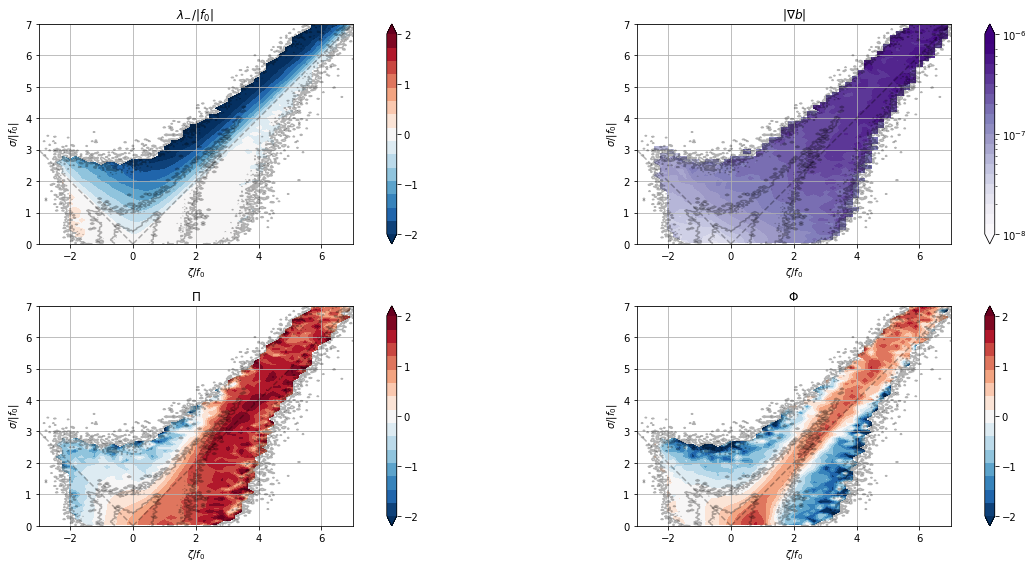

In [27]:
fig, ax = plt.subplots(2,2, figsize=(18,8))


tempJpdf01 = (1/(binbox01new*girbNums01)*(hist01new.rename('')).mean(dim='time'))

levels_norm_vars = np.linspace(-2,2,16)

hist01_lambda_test = xr.where(tempJpdf01<1e-5,np.nan,hist01_lambda)

im02 = ax[0,0].contourf(hist01new.vort1_0_bin, hist01new.strain1_0_bin, ((hist01_lambda_test)/hist01new).mean(dim='time').T, 
             levels = levels_norm_vars, vmax=2, vmix=-2, cmap='RdBu_r',extend='both', rasterized=True)

h02 = fig.colorbar(im02, ax=ax[0,0])
h02.set_ticks([-2, -1, 0, 1, 2])
#h02.set_ticks([-2, -1.2, -0.4, 0.4, 1.2, 2])
#h02.ax.set_ticklabels([-2, -1.2, -0.4, 0.4, 1.2, 2])
ax[0,0].set_aspect('equal')
ax[0,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hist01.mean(dim='time').T), levels=[1e-5], colors='k', alpha=.3)
ax[0,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hist05.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
ax[0,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239),((20**2)/(binbox01old*2000*1000)*hist20.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
ax[0,0].set_title('$\lambda_{-}$/$|f_0|$ ')
ax[0,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0,0].set_xlabel('$\zeta/f_0$')
ax[0,0].set_ylabel('$\sigma/|f_0|$')
ax[0,0].set_ylim(0,7)
ax[0,0].set_xlim(-3,7)
ax[0,0].grid()


hist01_fqgeo_test = xr.where(tempJpdf01<1e-5,np.nan,hist01_fqgeo)
im00 = ax[1,0].contourf(hist01new.vort1_0_bin, hist01new.strain1_0_bin, ((hist01_fqgeo_test)/hist01new).mean(dim='time').T, 
             levels = levels_norm_vars, vmax=2, vmix=-2, cmap='RdBu_r',extend='both', rasterized=True)
h00 = fig.colorbar(im00, ax=ax[1,0])
h00.set_ticks([-2, -1, 0, 1, 2])
ax[1,0].set_aspect('equal')
ax[1,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hist01.mean(dim='time').T), levels=[1e-5], colors='k', alpha=.3)
ax[1,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hist05.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
ax[1,0].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239),((20**2)/(binbox01old*2000*1000)*hist20.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
ax[1,0].set_title('$\Pi$', color='k')
ax[1,0].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1,0].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1,0].set_xlabel('$\zeta/f_0$')
ax[1,0].set_ylabel('$\sigma/|f_0|$')
ax[1,0].set_ylim(0,7)
ax[1,0].set_xlim(-3,7)
ax[1,0].grid()



hist01_Lqgeo_test = xr.where(tempJpdf01<1e-5,np.nan,hist01_Lqgeo)
im01 = ax[1,1].contourf(hist01new.vort1_0_bin, hist01new.strain1_0_bin, ((hist01_Lqgeo_test)/hist01new).mean(dim='time').T, 
             levels = levels_norm_vars, vmax=2, vmix=-2, cmap='RdBu_r', extend='both', rasterized=True)
h01 = fig.colorbar(im01, ax=ax[1,1])
h01.set_ticks([-2, -1, 0, 1, 2])
ax[1,1].set_aspect('equal')
ax[1,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hist01.mean(dim='time').T), levels=[1e-5], colors='k', alpha=.3)
ax[1,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hist05.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
ax[1,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239),((20**2)/(binbox01old*2000*1000)*hist20.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
ax[1,1].set_title('$\Phi$', color='k')
ax[1,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[1,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[1,1].set_xlabel('$\zeta/f_0$')
ax[1,1].set_ylabel('$\sigma/|f_0|$')
ax[1,1].set_ylim(0,7)
ax[1,1].set_xlim(-3,7)
ax[1,1].grid()






hist01_gfmsel_test = xr.where(tempJpdf01<1e-5,np.nan,hist01_gfmsel)
im11 = ax[0,1].pcolormesh(hist01new.vort1_0_bin, hist01new.strain1_0_bin, ((hist01_gfmsel_test)/hist01new).mean(dim='time').T, 
             vmax=1e-6,norm=cols.SymLogNorm(1e-8), cmap='Purples', rasterized=True)

im11 = ax[0,1].contourf(hist01new.vort1_0_bin, hist01new.strain1_0_bin, ((hist01_gfmsel_test)/hist01new).mean(dim='time').T, 
             levels = np.logspace(-8, -6, 21),#[1e-8,3e-8, 5e-8, 8e-8, 1e-7, 3e-7, 5e-7],
#                         levels = [1e-7, 2.5e-7, 5e-7, 7.5e-7, 1e-6],
                        norm=colors.LogNorm(vmin=1e-8, vmax=0.75e-6),
                        cmap='Purples',extend='both', rasterized=True)

h11 = fig.colorbar(im11, ax=ax[0,1])
h11.set_ticks([1e-8, 1e-7, 1e-6])
ax[0,1].set_aspect('equal')
ax[0,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01old*2000*1000)*hist01.mean(dim='time').T), levels=[1e-5], colors='k', alpha=.3)
ax[0,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01old*2000*1000)*hist05.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
ax[0,1].contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239),((20**2)/(binbox01old*2000*1000)*hist20.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
ax[0,1].set_title('$|\\nabla b|$', color='k')
ax[0,1].plot(np.linspace(0,-7,29),np.linspace(0,7,29),'k--',alpha=.3)
ax[0,1].plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.3)
ax[0,1].set_xlabel('$\zeta/f_0$')
ax[0,1].set_ylabel('$\sigma/|f_0|$')
ax[0,1].set_ylim(0,7)
ax[0,1].set_xlim(-3,7)
ax[0,1].grid()


plt.tight_layout()
# plt.savefig("fig5-2.pdf", bbox_inches = "tight")